In [119]:
from sklearn import tree
import pandas as pd
import pathlib
import os
import numpy as np

In [122]:
here = pathlib.Path(os.path.abspath(''))
exercise_dir = here.parent
data_dir = exercise_dir.parent / "data"
train_df = pd.read_csv(data_dir / "titanic_train.csv")

# sex,  PClass, age: survived

In [123]:
train_df["TotalRelatives"] = train_df["SibSp"] + train_df["Parch"]
train_df = train_df.drop(columns=["Name", "SibSp", "Parch", "Ticket", "Fare", "Cabin", "Embarked"])
train_df["Sex"] = train_df["Sex"].apply(lambda x: 0 if x == "female" else 1)
age_mean = train_df["Age"].mean()
train_df["Age"] = train_df["Age"].fillna(age_mean) #fill NaNs with distributed age

train_df


,PassengerId,Survived,Pclass,Sex,Age,TotalRelatives
0,565,0,3,0,29.567002,0
1,858,1,1,1,51.000000,0
2,129,1,3,0,29.567002,2
3,612,0,3,1,29.567002,0
4,67,1,2,0,29.000000,0
...,...,...,...,...,...,...
752,816,0,1,1,29.567002,0
753,254,0,3,1,30.000000,1
754,642,1,1,0,24.000000,0
755,480,1,3,0,2.000000,1


In [114]:
# this decreases performance:

def get_distributed_age():
    """
    Method that returns an random age based off the age distribution found in ALL of the data
    """
    age_ranges = {(0, 3), (3, 13 ), (13,  20), (20,  35), (35, 60), (60, 100)}
    age_group_distribution = [30/715, 41/715, 108/715,318/715, 195/715, 23/715]
    random_group = np.random.choice(age_ranges, p=age_group_distribution)#age groups according to analysis last week
    actual_value = np.random(random_group[0], random_group[1])#geerate actual random age based off the age groups upper and lower boundaries
    return actual_value
    
# train_df["Age"] = train_df["Age"].apply(lambda x: get_distributed_age() if x == np.nan else x)#fill NaNs with distributed age


TypeError: unhashable type: 'Series'

In [130]:
from sklearn.model_selection import train_test_split
from sklearn import tree
classifier = tree.DecisionTreeClassifier(max_depth=4)
x = train_df.iloc[:, 2:]
y = train_df[["Survived"]]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)


In [131]:
classifier.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=4)

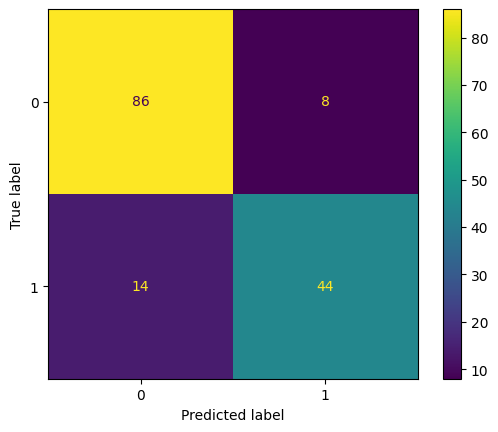

In [132]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, x_test, y_test)

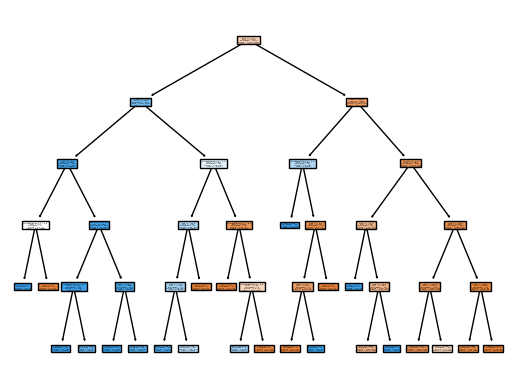

In [127]:
from sklearn.inspection import DecisionBoundaryDisplay, permutation_importance
import matplotlib.pyplot as plt
tree.plot_tree(classifier, feature_names=x_train.columns, class_names=["survived", "died"], filled=True)
plt.savefig('out.pdf')

In [133]:
from sklearn.metrics import matthews_corrcoef

y_pred = classifier.predict(x_test)
y_pred = pd.DataFrame(y_pred, columns=["prediction"], index=y_test.index)
matthews_corrcoef(y_test, y_pred)

0.6896410066833436

In [134]:
# is the model overfitted?
matthews_corrcoef(y_train, classifier.predict(x_train))


0.6460664221538672

In [46]:
# the data is well distributed and best with test_data of 20%
from sklearn.model_selection import cross_val_score
scores = cross_val_score(classifier, x, y, cv=5) 
scores

array([0.79605263, 0.80921053, 0.78807947, 0.77483444, 0.8013245 ])